<a href="https://colab.research.google.com/github/kiplangatkorir/Bayesian-GARCH/blob/main/bayesian_garch(1%2C1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
pip install pymc arviz

Output()

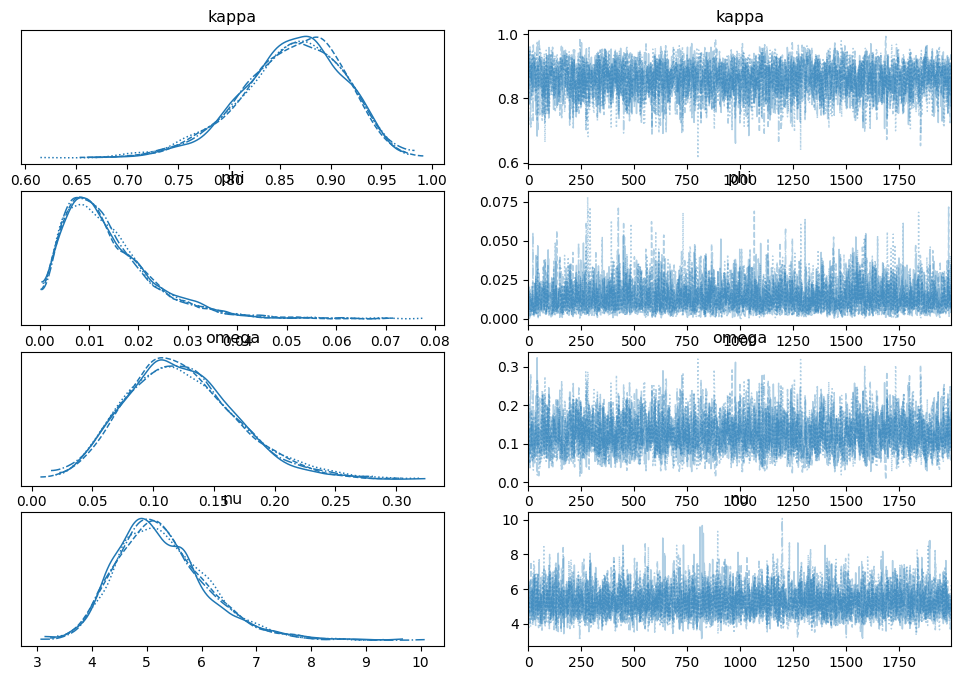

        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
kappa  0.862  0.050   0.766    0.951      0.001    0.001    2600.0    2585.0   
phi    0.014  0.009   0.001    0.030      0.000    0.000    3109.0    3199.0   
omega  0.124  0.046   0.039    0.208      0.001    0.001    2714.0    2682.0   
nu     5.279  0.829   3.888    6.886      0.013    0.013    4256.0    3566.0   

       r_hat  
kappa    1.0  
phi      1.0  
omega    1.0  
nu       1.0  


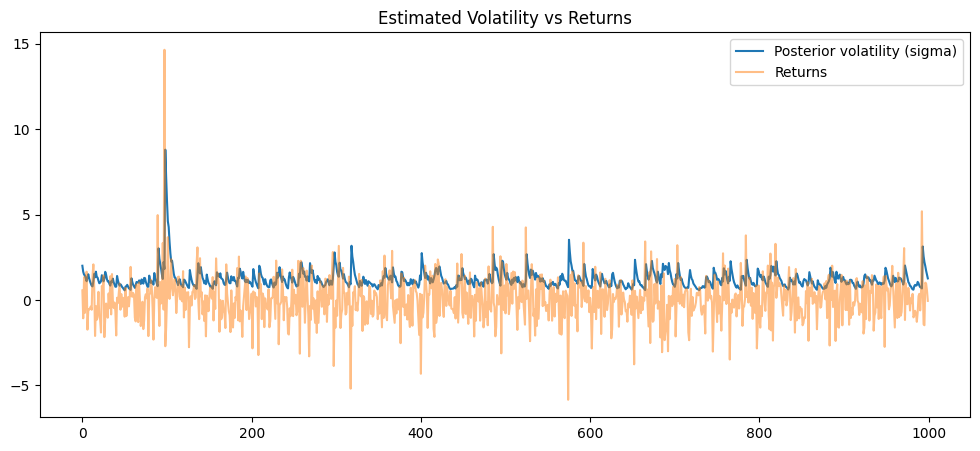

Output()

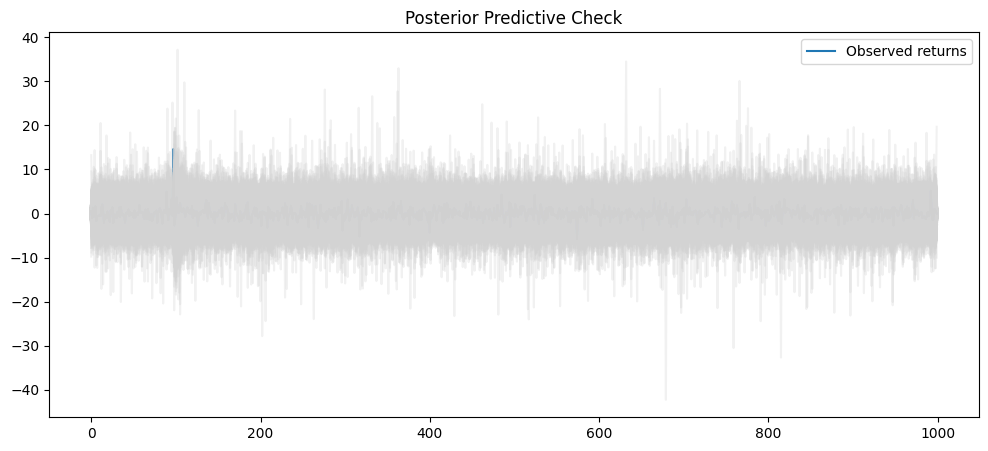

One-step-ahead forecasted volatility: 1.2158
1% Value-at-Risk estimate: -2.8280
1% Expected Shortfall estimate: -3.2431


In [11]:
# ===============================
# Bayesian GARCH(1,1) Workflow
# ===============================

import pymc as pm
import pytensor.tensor as pt
from pytensor.scan import scan
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

# -------------------------------
# 1. Data Preparation
# -------------------------------

# Example: generate synthetic returns
np.random.seed(42)
T = 1000
returns = np.random.standard_t(df=5, size=T).astype("float64")
returns -= returns.mean()  # demeaned returns

# -------------------------------
# 2. Define Bayesian GARCH(1,1) Model
# -------------------------------

with pm.Model() as garch_model:

    # --- Priors ---
    kappa = pm.Beta("kappa", alpha=20, beta=1.5)
    phi   = pm.Beta("phi", alpha=2, beta=2)

    alpha = pm.Deterministic("alpha", kappa * phi)
    beta  = pm.Deterministic("beta", kappa * (1 - phi))

    omega = pm.HalfNormal("omega", sigma=0.1)
    nu = pm.Exponential("nu_raw", 0.1) + 2
    pm.Deterministic("nu", nu)

    # --- Initial variance ---
    sigma2_0 = omega / (1 - alpha - beta)

    # --- Volatility recursion ---
    def garch_step(r_tm1, sigma2_tm1, omega, alpha, beta):
        return omega + alpha * r_tm1**2 + beta * sigma2_tm1

    sigma2, _ = scan(
        fn=garch_step,
        sequences=returns[:-1],
        outputs_info=sigma2_0,
        non_sequences=[omega, alpha, beta],
    )

    sigma2 = pt.concatenate([[sigma2_0], sigma2])
    sigma = pt.sqrt(pt.maximum(sigma2, 1e-8))

    # --- Likelihood ---
    pm.StudentT(
        "obs",
        nu=nu,
        mu=0.0,
        sigma=sigma,
        observed=returns,
    )

    # -------------------------------
    # 3. Sampling
    # -------------------------------
    trace = pm.sample(
        draws=2000,
        tune=2000,
        chains=4,
        target_accept=0.9,
        random_seed=42
    )

# -------------------------------
# 4. Posterior Diagnostics
# -------------------------------

# Trace plots
az.plot_trace(trace, var_names=["kappa", "phi", "omega", "nu"])
plt.show()

# Summary statistics
summary = az.summary(trace, var_names=["kappa", "phi", "omega", "nu"])
print(summary)

# -------------------------------
# 5. Posterior Volatility Plot
# -------------------------------

# Evaluate posterior mean of sigma^2
sigma2_post_mean = sigma2.eval()
plt.figure(figsize=(12,5))
plt.plot(np.sqrt(sigma2_post_mean), label="Posterior volatility (sigma)")
plt.plot(returns, alpha=0.5, label="Returns")
plt.legend()
plt.title("Estimated Volatility vs Returns")
plt.show()

# -------------------------------
# 6. Posterior Predictive Check
# -------------------------------
with garch_model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["obs"], random_seed=42)

# In PyMC 5+, ppc is an InferenceData object
ppc_obs = ppc.posterior_predictive["obs"].values  # shape: (chains, draws, T)

# Combine chains and draws for plotting
ppc_obs_combined = ppc_obs.reshape(-1, ppc_obs.shape[-1])

plt.figure(figsize=(12,5))
plt.plot(returns, label="Observed returns")
plt.plot(ppc_obs_combined.T, color='lightgray', alpha=0.3)
plt.title("Posterior Predictive Check")
plt.legend()
plt.show()


# -------------------------------
# 7. One-step Ahead Volatility Forecast
# -------------------------------

alpha_mean = trace.posterior["alpha"].mean().values
beta_mean  = trace.posterior["beta"].mean().values
omega_mean = trace.posterior["omega"].mean().values

sigma2_next = omega_mean + alpha_mean * returns[-1]**2 + beta_mean * sigma2_post_mean[-1]
sigma_next = np.sqrt(sigma2_next)
print(f"One-step-ahead forecasted volatility: {sigma_next:.4f}")

# -------------------------------
# 8. Simple Risk Measures
# -------------------------------

# Using last sigma as VaR for 1% quantile
VaR_1pct = -sigma_next * 2.326  # 1% quantile of standard normal
print(f"1% Value-at-Risk estimate: {VaR_1pct:.4f}")

# Expected Shortfall approximation (1% tail)
ES_1pct = -sigma_next * (1/(0.01)) * (1/np.sqrt(2*np.pi)) * np.exp(-2.326**2 / 2)
print(f"1% Expected Shortfall estimate: {ES_1pct:.4f}")
